In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load semantic model
# The SemanticModel class is something I wrote to make it easy to deal with vector-space semantic models.
from SemanticModel import SemanticModel
eng1000 = SemanticModel.load("data/english1000sm.hf5")

In [3]:

# These are lists of the stories
# Rstories are the names of the training (or Regression) stories, which we will use to fit our models
Rstories = ['alternateithicatom', 'avatar', 'howtodraw', 'legacy', 
            'life', 'myfirstdaywiththeyankees', 'naked', 
            'odetostepfather', 'souls', 'undertheinfluence']

# Pstories are the test (or Prediction) stories (well, story), which we will use to test our models
Pstories = ['wheretheressmoke']

allstories = Rstories + Pstories

# Load TextGrids
from stimulus_utils import load_grids_for_stories
grids = load_grids_for_stories(allstories)

# Load TRfiles
from stimulus_utils import load_generic_trfiles
trfiles = load_generic_trfiles(allstories)

# Make word and phoneme datasequences
from dsutils import make_word_ds, make_phoneme_ds
wordseqs = make_word_ds(grids, trfiles) # dictionary of {storyname : word DataSequence}
phonseqs = make_phoneme_ds(grids, trfiles) # dictionary of {storyname : phoneme DataSequence}

In [4]:

naked = wordseqs["naked"]
# The DataSequence stores a lot of information
# naked.data is a list of all the words in the story
print ("There are %d words in the story called 'naked'" % len(list(naked.data)))

There are 3218 words in the story called 'naked'


In [5]:

# Project stimuli
from dsutils import make_semantic_model
semanticseqs = dict() # dictionary to hold projected stimuli {story name : projected DataSequence}
for story in allstories:
    semanticseqs[story] = make_semantic_model(wordseqs[story], eng1000)

In [6]:

# take a look at the projected stimuli
naked_proj = semanticseqs["naked"]

print (naked_proj.data.shape) # prints the shape of 'data' as (rows, columns)
print (naked_proj.data[:10]) # print the first 10 rows (this will be truncated)

(3218, 985)
[[-0.48074415  0.10393176 -0.45596143 ... -0.03175243 -0.62248756
  -0.32170921]
 [ 0.09911849  0.06500191 -0.78847992 ...  1.95413789 -0.94043714
  -1.0863888 ]
 [-0.73058513 -0.37099858 -0.59858174 ... -0.30655477 -0.30774183
  -0.66815734]
 ...
 [ 0.59646679  0.31843488  0.78981277 ...  0.21670864 -1.09263289
  -1.26290446]
 [-0.61541241 -1.1005762  -0.33248156 ...  0.23637707 -1.5470721
  -0.6521566 ]
 [ 0.3866531  -0.05810349 -0.63087673 ...  0.43836955 -1.03314247
  -0.57172974]]


In [7]:

# Downsample stimuli
interptype = "lanczos" # filter type
window = 3 # number of lobes in Lanczos filter

downsampled_semanticseqs = dict() # dictionary to hold downsampled stimuli
for story in allstories:
    downsampled_semanticseqs[story] = semanticseqs[story].chunksums(interptype, window=window)

Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


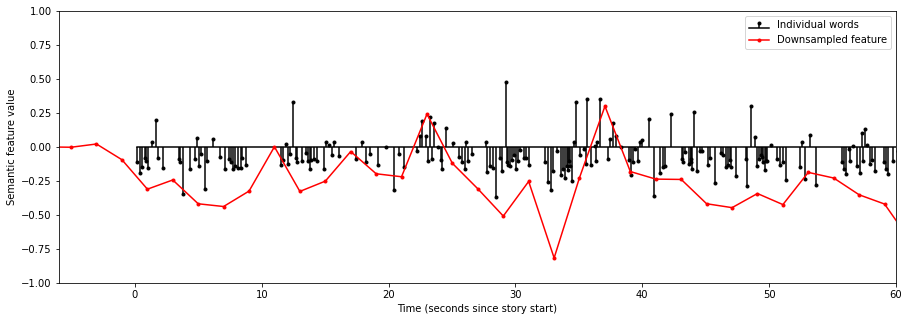

In [8]:

# Plot the result
s_words = wordseqs["naked"]
s_sem = semanticseqs["naked"]
s_semdown = downsampled_semanticseqs["naked"]

f = plt.figure(figsize=(15,5))
f.clf()
schan = 2
ax = f.add_subplot(1,1,1)
wordstems = ax.stem(s_sem.data_times, 
                    s_sem.data[:,schan] / np.abs(s_sem.data[:,schan]).max(), 
                    linefmt="k-", markerfmt="k.", basefmt="k-")
interps = ax.plot(s_sem.tr_times, 
                  s_semdown[:,schan] / np.abs(s_semdown[:,schan]).max(), 'r.-')
ax.set_xlim(-6, 60)
ax.set_ylim(-1, 1)
ax.set_xlabel("Time (seconds since story start)")
ax.set_ylabel("Semantic feature value")
ax.legend((wordstems, interps[0]), ("Individual words", "Downsampled feature"));

In [9]:

# Combine stimuli
from npp import zscore
trim = 5
Rstim = np.vstack([zscore(downsampled_semanticseqs[story][5+trim:-trim]) for story in Rstories])
Pstim = np.vstack([zscore(downsampled_semanticseqs[story][5+trim:-trim]) for story in Pstories])

In [10]:

storylens = [len(downsampled_semanticseqs[story][5+trim:-trim]) for story in Rstories]
print(storylens)

print(np.cumsum(storylens))

[343, 367, 354, 400, 430, 358, 422, 404, 355, 304]
[ 343  710 1064 1464 1894 2252 2674 3078 3433 3737]


In [11]:

# Delay stimuli
from util import make_delayed
ndelays = 4
delays = range(1, ndelays+1)

print ("FIR model delays: ", delays)

delRstim = make_delayed(Rstim, delays)
delPstim = make_delayed(Pstim, delays)

FIR model delays:  range(1, 5)


In [12]:

# Load responses
import tables
resptf = tables.open_file("data/fmri-responses.hf5")
zRresp = resptf.root.zRresp.read()
zPresp = resptf.root.zPresp.read()
mask = resptf.root.mask.read()

In [13]:

# Run regression
from ridge import bootstrap_ridge
alphas = np.logspace(1, 3, 10) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 1 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 20

wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(delRstim, zRresp, delPstim, zPresp,
                                                     alphas, nboots, chunklen, nchunks,
                                                     singcutoff=1e-10, single_alpha=True)

In [14]:

# Then let's predict responses by taking the dot product of the weights and stim
pred = np.dot(delPstim, wt)

print ("pred has shape: ", pred.shape)

pred has shape:  (291, 37226)


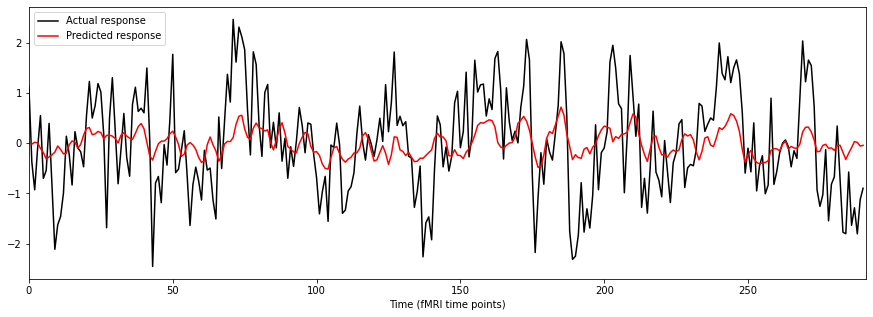

In [16]:

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

selvox = 20710 # a decent voxel

realresp = ax.plot(zPresp[:,selvox], 'k')[0]
predresp = ax.plot(pred[:,selvox], 'r')[0]

ax.set_xlim(0, 291)
ax.set_xlabel("Time (fMRI time points)")

ax.legend((realresp, predresp), ("Actual response", "Predicted response"));

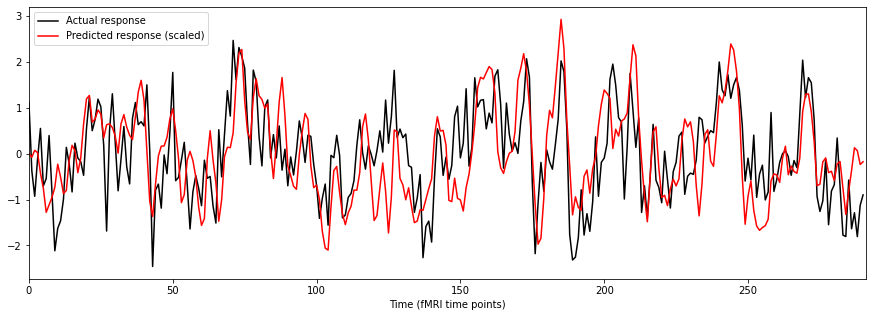

In [17]:

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

selvox = 20710 # a good voxel

realresp = ax.plot(zPresp[:,selvox], 'k')[0]
predresp = ax.plot(zscore(pred[:,selvox]), 'r')[0]

ax.set_xlim(0, 291)
ax.set_xlabel("Time (fMRI time points)")

ax.legend((realresp, predresp), ("Actual response", "Predicted response (scaled)"));

In [18]:

# Compute correlation between single predicted and actual response
# (np.corrcoef returns a correlation matrix; pull out the element [0,1] to get 
# correlation between the two vectors)
voxcorr = np.corrcoef(zPresp[:,selvox], pred[:,selvox])[0,1]
print ("Correlation between predicted and actual responses for voxel %d: %f" % (selvox, voxcorr))

Correlation between predicted and actual responses for voxel 20710: 0.593783


[ 0.05682109 -0.02634303 -0.03431781 ... -0.08442223  0.08456757
 -0.04400821]


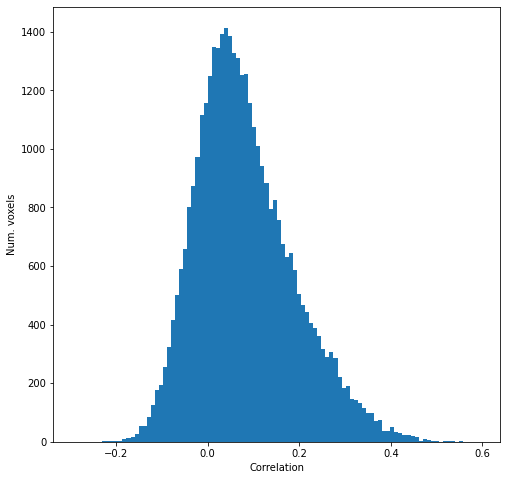

In [20]:

voxcorrs = np.zeros((zPresp.shape[1],)) # create zero-filled array to hold correlations
for vi in range(zPresp.shape[1]):
    voxcorrs[vi] = np.corrcoef(zPresp[:,vi], pred[:,vi])[0,1]
print (voxcorrs)

# Plot histogram of correlations
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(1,1,1)
ax.hist(voxcorrs, 100) # histogram correlations with 100 bins
ax.set_xlabel("Correlation")
ax.set_ylabel("Num. voxels");

In [ ]:
import torch

In [48]:

X = torch.from_numpy(delRstim).float()
Y = torch.from_numpy(zRresp).float()

In [61]:
model_linear = torch.nn.Sequential(torch.nn.Linear(delRstim.shape[-1], mask.sum())) 

opt = torch.optim.Adam(model_linear.parameters(), lr=1e-3, weight_decay=alphas.mean())

bs = 10
all_idxs = np.arange(len(X))


for epoch_idx in range(100)[:1]:
    all_batch_idxs = [all_idxs[i: i+bs] for i in range(0, len(all_idxs), bs)]
    for batch_idxs in all_batch_idxs:
        print('here')
        X_batch = X[batch_idxs]
        Y_batch = Y[batch_idxs]
        Y_batch_pred = model_linear(X_batch)
        print('fjewaio')
    
        loss = (Y_batch-Y_batch_pred).pow(2).mean()

        opt.zero_grad()
        loss.backward()
        opt.step()
        print(loss.item())


here
fjewaio
1.4269267320632935
here
fjewaio
1.2254501581192017
here
fjewaio
1.1562484502792358
here
fjewaio
0.9785248637199402
here
fjewaio
1.050196886062622
here
fjewaio
1.2838822603225708
here
fjewaio
1.2703667879104614
here
fjewaio
1.0054939985275269
here
fjewaio
1.0577603578567505
here
fjewaio
0.8739502429962158
here
fjewaio
1.22740638256073
here
fjewaio
1.0034394264221191
here
fjewaio
1.1387742757797241
here
fjewaio
0.9936187863349915
here
fjewaio
0.8674662113189697
here
fjewaio
0.8729360699653625
here
fjewaio
0.8797261714935303
here
fjewaio
0.9479416012763977
here
fjewaio
0.8116519451141357
here
fjewaio
0.9408112168312073
here
fjewaio
1.1849300861358643
here
fjewaio
1.1259254217147827
here
fjewaio
1.1100386381149292
here
fjewaio
0.9741470217704773
here
fjewaio
1.0639503002166748
here
fjewaio
0.9214779138565063
here
fjewaio
1.1155585050582886
here
fjewaio
1.0252631902694702
here
fjewaio
0.9695313572883606
here
fjewaio
1.218024492263794
here
fjewaio
1.1197839975357056
here
fjewaio

KeyboardInterrupt: 